In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, shape)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import (running_mean_APWP, running_mean_APWP_shape, RM_stats, get_pseudo_vgps, get_vgps_sampling_direction, 
                                  running_mean_VGPs_bootstrapped, running_mean_bootstrapping_direction)

from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble, quantiles

## Compiles a DataFrame for both, the VGPs and the recomputed poles by study

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [3]:
df_filtered_vgps, df_pole_compilation = dfs_vgps_recomputed_poles(data_path_VGP, by_study = False) # takes as many as poles as are described for one are

## Set the hyperparameters for further comparissons.

In [70]:
min_age = 0
max_age = 65
window_length = 20
time_step = 10
# define a list to store all the models
models = []

### 1. Running means classic approach on poles

In [71]:
RM_1_classic_by_study = running_mean_APWP (df_pole_compilation, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_1_classic_by_study['method'] = "RM_classic"
models.append(RM_1_classic_by_study)
RM_1_classic_by_study.head(5)

,age,N,n_studies,k,A95,csd,plon,plat,method
0,0.0,17.0,15.0,155.075584,2.873466,6.504491,-62.819531,-87.321010,RM_classic
1,10.0,18.0,15.0,154.995795,2.785329,6.506165,-54.986373,-87.258735,RM_classic
2,20.0,7.0,6.0,576.253052,2.516820,3.374259,-11.644529,-81.643535,RM_classic
3,30.0,10.0,7.0,352.037229,2.578271,4.317086,-27.417630,-82.908968,RM_classic
4,40.0,13.0,8.0,106.788061,4.029946,7.838332,-42.018275,-83.233935,RM_classic


### 2. Running means ensemble from pseudo-VGPs approach (Vaes et al. 2022)

In [58]:
%%time
RM_2_ensemble_pseudoVGP = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):   
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation)
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP_shape(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i

    RM_2_ensemble_pseudoVGP = RM_2_ensemble_pseudoVGP.append(RM_APWP_parametric_temp, ignore_index=True)
RM_2_ensemble_pseudoVGP['plon'] = RM_2_ensemble_pseudoVGP.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)    
RM_2_ensemble_pseudoVGP['method'] = "RM_pseudoVGPs_ensemble"
models.append(RM_2_ensemble_pseudoVGP)

CPU times: user 46.9 s, sys: 323 ms, total: 47.2 s
Wall time: 47.2 s


Set quantiles

In [59]:
RM_2_quantiles_plat = quantiles(RM_2_ensemble_pseudoVGP,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_2_quantiles_plon = quantiles(RM_2_ensemble_pseudoVGP,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_2_ensemble_pseudoVGP.head(3)

,run,n_studies,k,A95,csd,age,N,plon,plat,foliation,lineation,collinearity,coplanarity,method
0,0,15.0,23.63167,1.631454,16.66241,0.0,328.0,-44.585688,-88.446719,0.129082,0.575699,4.459954,0.704781,RM_pseudoVGPs_ensemble
1,0,15.0,23.66903,1.603326,16.649254,2.0,339.0,-40.486468,-88.321220,0.125497,0.587312,4.679877,0.712810,RM_pseudoVGPs_ensemble
2,0,15.0,23.672887,1.579955,16.647898,4.0,349.0,-41.842681,-88.275660,0.140469,0.551961,3.929422,0.692430,RM_pseudoVGPs_ensemble


## 3. Running means on VGPs. 
Three different approachs as follows:
### 3.1. Running means on the computed dataset (one run and A95)

In [60]:
RM_31_on_VGP = running_mean_APWP(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age)
RM_31_on_VGP['method'] = "RM_classic_VGPs"
models.append(RM_31_on_VGP)

In [61]:
RM_31_on_VGP.head(3)

,age,N,n_studies,k,A95,csd,plon,plat,method
0,0.0,305.0,15.0,23.294563,1.704883,16.782542,-42.916770,-87.945102,RM_classic_VGPs
1,2.0,308.0,15.0,22.847346,1.713794,16.945998,-45.430085,-88.076649,RM_classic_VGPs
2,4.0,309.0,15.0,22.671004,1.717952,17.011775,-45.363582,-87.974789,RM_classic_VGPs


### 3.2. Running means on random samples (with replacement) from the original dataset to generate an ensemble of possible solution.

In [62]:
%%time
RM_32_boots_VGPs=running_mean_VGPs_bootstrapped(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age, n_bst = 100)
RM_32_boots_VGPs['method']="RM_bootstrapped_VGPs_ensemble"
models.append(RM_32_boots_VGPs)

CPU times: user 30 s, sys: 132 ms, total: 30.2 s
Wall time: 30.2 s


Set quantiles

In [63]:
RM_32_quantiles_plat = quantiles(RM_32_boots_VGPs,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_32_quantiles_plon = quantiles(RM_32_boots_VGPs,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_32_boots_VGPs.head(3)

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
0,0.0,308.0,26.390924,1.589721,15.767314,0.124688,0.783858,6.286532,0.908546,0.0,13.0,4.420579,-88.743276,RM_bootstrapped_VGPs_ensemble
1,0.0,310.0,25.813806,1.60288,15.942594,0.134499,0.776089,5.770208,0.910588,2.0,13.0,8.029957,-88.928257,RM_bootstrapped_VGPs_ensemble
2,0.0,312.0,25.304382,1.614366,16.102272,0.130768,0.764041,5.842717,0.894809,4.0,13.0,0.065087,-88.792886,RM_bootstrapped_VGPs_ensemble


### 3.3. Propation of directional error towards the VGP level. 
We take the original directions as a PDF to generate to generate a pseudo-Dataset that incorporates the uncertinty in the directional space and time. We aaply the running means on a number of $pseudo$-VGPs to generate an ensemble of possible paths

In [64]:
%%time
RM_33_propagation=running_mean_bootstrapping_direction(df_filtered_vgps,'plon', 'plat', 'age', window_length, time_step, max_age, min_age, n_bst = 100)
RM_33_propagation['method']="RM_DirErrorPropagated_ensemble"
models.append(RM_33_propagation)

CPU times: user 1min 2s, sys: 406 ms, total: 1min 2s
Wall time: 1min 2s


Set quantiles

In [65]:
RM_33_quantiles_plat = quantiles(RM_33_propagation,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_33_quantiles_plon = quantiles(RM_33_propagation,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_33_propagation.head(3)

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
0,0.0,306.0,18.067242,1.94533,19.056322,0.088995,0.578538,6.500818,0.667533,0.0,15.0,-43.574284,-86.830032,RM_DirErrorPropagated_ensemble
1,0.0,306.0,18.067242,1.94533,19.056322,0.088995,0.578538,6.500818,0.667533,2.0,15.0,-43.574284,-86.830032,RM_DirErrorPropagated_ensemble
2,0.0,310.0,17.892321,1.942658,19.149246,0.105128,0.561627,5.34231,0.666756,4.0,15.0,-44.428163,-86.758148,RM_DirErrorPropagated_ensemble


## Get APW from Muller et al., 2016 and Torsvik and Cocks, 2017

- Müller, R. D., Seton, M., Zahirovic, S., Williams, S. E., Matthews, K. J., Wright, N. M., ... & Cannon, J. (2016). Ocean basin evolution and global-scale plate reorganization events since Pangea breakup. Annual Review of Earth and Planetary Sciences, 44, 107-138. DOI:10.1146/annurev-earth-060115-012211
- Torsvik, T. H., & Cocks, L. R. M. (2013). Gondwana from top to base in space and time. Gondwana Research, 24(3-4), 999-1030.


In [66]:
Torsvik2017_path = np.loadtxt('model_APWP/code_output/NAM_0_60_torsvik_2017.txt', )
Torsvik2017_path_df = pd.DataFrame(Torsvik2017_path, columns = ['age','plon', 'plat', 'Euler_angle', 'Euler_lon', 'Euler_lat'])
Torsvik2017_path_df = Torsvik2017_path_df[Torsvik2017_path_df['age']>0]
Torsvik2017_path_df['method'] = "plate model"
models.append(Torsvik2017_path_df)

Mueller2016_path = np.loadtxt('model_APWP/code_output/NAM_0_60_muller_2016.txt', )
Mueller2016_path_df = pd.DataFrame(Mueller2016_path, columns = ['age','plon', 'plat', 'Euler_angle', 'Euler_lon', 'Euler_lat'])
Mueller2016_path_df = Mueller2016_path_df[Mueller2016_path_df['age']>0]
Mueller2016_path_df['method']="plate model"
models.append(Mueller2016_path_df)

Merge

In [67]:
df_all = pd.concat(models, axis=0)
df_all.head()

,age,N,n_studies,k,A95,csd,plon,plat,method,run,foliation,lineation,collinearity,coplanarity,Euler_angle,Euler_lon,Euler_lat
0,0.0,17.0,15.0,155.075584,2.873466,6.504491,-62.819531,-87.321010,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,18.0,15.0,154.995795,2.785329,6.506165,-54.986373,-87.258735,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,18.0,15.0,154.995795,2.785329,6.506165,-54.986373,-87.258735,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.0,18.0,15.0,154.995795,2.785329,6.506165,-54.986373,-87.258735,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,18.0,15.0,154.995795,2.785329,6.506165,-54.986373,-87.258735,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Comparisons plot

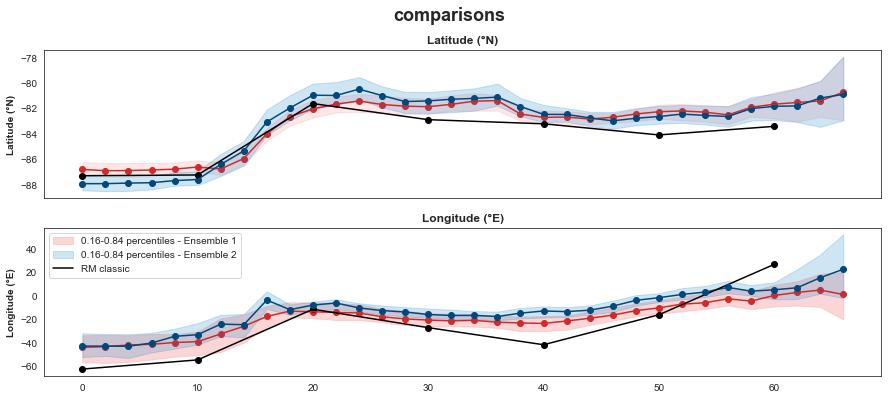

In [72]:
title = "comparisons"

ensemble1_lon = RM_2_quantiles_plon
ensemble1_lat = RM_2_quantiles_plat

ensemble2_lat = RM_33_quantiles_plat
ensemble2_lon = RM_33_quantiles_plon

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')
# LATITUDE
# axes[0].scatter(RM_ensemble_pseudoVGP['age'],RM_ensemble_pseudoVGP['plat'], s = 1, color = 'black', alpha = 0.2)
# axes[0].fill_between(ensemble1_lat.X, ensemble1_lat.q5,ensemble1_lat.q95, color= "#f9afaf", alpha=.20,label="Running mean on VGPs ensemble")
axes[0].fill_between(ensemble1_lat.X, ensemble1_lat.q25,ensemble1_lat.q75, color= "#f98787", alpha=.20)
# axes[0].plot(a.X, a.mean, '--', color="#ad3131",label="mean")
axes[0].plot(ensemble1_lat.X, ensemble1_lat.q50, '-',color="#d12a2a")
axes[0].scatter(ensemble1_lat.X, ensemble1_lat.q50,color="#d12a2a")

# axes[0].scatter(RM_ensemble_VGPs['age'],RM_ensemble_VGPs['plat'], s = 1, color = 'black', alpha = 0.2)
# axes[0].fill_between(ensemble2_lat.X, ensemble2_lat.q5,ensemble2_lat.q95, color= "#1CA0F9", alpha=.20,label="Running mean on $pseudo$-VGPs")
axes[0].fill_between(ensemble2_lat.X, ensemble2_lat.q25,ensemble2_lat.q75, color= "#0E7DC9", alpha=.20)
# axes[0].plot(a.X, a.mean, '--', color="#ad3131",label="mean")
axes[0].plot(ensemble2_lat.X, ensemble2_lat.q50, '-',color="#00497A")
axes[0].scatter(ensemble2_lat.X, ensemble2_lat.q50,color="#00497A")

axes[0].plot(RM_1_classic_by_study.age, RM_1_classic_by_study.plat, '-',color="black") #CLASSIC
axes[0].scatter(RM_1_classic_by_study.age, RM_1_classic_by_study.plat, color="black") #CLASSIC

# LONGITUDE
#axes[1].scatter(RM_ensemble_VGPs['age'],RM_ensemble_VGPs['plon'], s = 1, color = 'black', alpha = 0.2)
axes[1].fill_between(ensemble1_lon.X, ensemble1_lon.q16,ensemble1_lon.q84, color= "#f9afaf", alpha=.50,label="0.16-0.84 percentiles - Ensemble 1")
# axes[1].fill_between(ensemble1_lon.X, ensemble1_lon.q25,ensemble1_lon.q75, color= "#f98787", alpha=.20, label="Running mean on $pseudo$-VGPs")
# axes[1].plot(a.X, a.mean, '--', color="#ad3131",label="mean")
axes[1].plot(ensemble1_lon.X, ensemble1_lon.q50, '-',color="#d12a2a")
axes[1].scatter(ensemble1_lon.X, ensemble1_lon.q50,color="#d12a2a")

# axes[0].scatter(RM_ensemble_VGPs['age'],RM_ensemble_VGPs['plat'], s = 1, color = 'black', alpha = 0.2)
# axes[1].fill_between(ensemble2_lon.X, ensemble2_lon.q5,ensemble2_lon.q95, color= "#1CA0F9", alpha=.20)
axes[1].fill_between(ensemble2_lon.X, ensemble2_lon.q25,ensemble2_lon.q75, color= "#0E7DC9", alpha=.20,label="0.16-0.84 percentiles - Ensemble 2")
# axes[0].plot(a.X, a.mean, '--', color="#ad3131",label="mean")
axes[1].plot(ensemble2_lon.X, ensemble2_lon.q50, '-',color="#00497A", zorder =2)
axes[1].scatter(ensemble2_lon.X, ensemble2_lon.q50,  color = "#00497A", alpha = 1, zorder =3)

axes[1].plot(RM_1_classic_by_study.age, RM_1_classic_by_study.plon, '-',color="black", label = "RM classic") #CLASSIC
axes[1].scatter(RM_1_classic_by_study.age, RM_1_classic_by_study.plon, color="black") #CLASSIC

# axes[1].set_ylim(-100, 50)
plt.legend(loc="upper left")

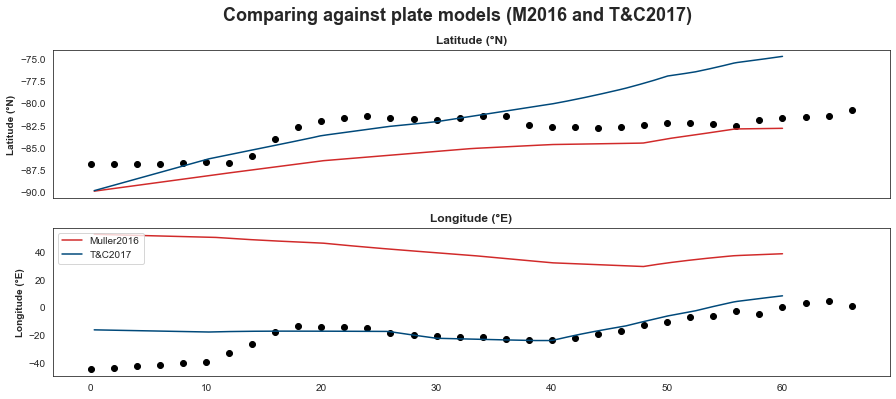

In [69]:
title = "Comparing against plate models (M2016 and T&C2017)"

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')
# LATITUDE

axes[0].plot(Mueller2016_path_df.age, Mueller2016_path_df.plat, '-',color="#d12a2a")
# axes[0].scatter(Mueller2016_path_df.age, Mueller2016_path_df.plat,s = 1, color="#d12a2a")
axes[0].plot(Torsvik2017_path_df.age, Torsvik2017_path_df.plat, '-',color="#00497A") #CLASSIC
# axes[0].scatter(Torsvik2017_path_df.age, Torsvik2017_path_df.plat, color="#00497A") #CLASSIC
axes[0].scatter(ensemble1_lat.X, ensemble1_lat.q50,color="black")
# LONGITUDE

axes[1].plot(Mueller2016_path_df.age, Mueller2016_path_df.plon, '-',color="#d12a2a", label = "Muller2016")
# axes[1].scatter(Mueller2016_path_df.age, Mueller2016_path_df.plon,color="#d12a2a")
axes[1].plot(Torsvik2017_path_df.age, Torsvik2017_path_df.plon, '-',color="#00497A", label = "T&C2017") #CLASSIC
# axes[1].scatter(Torsvik2017_path_df.age, Torsvik2017_path_df.plon, color="#00497A") #CLASSIC
axes[1].scatter(ensemble1_lon.X, ensemble1_lon.q50,color="black")

# axes[1].set_ylim(-100, 50)
plt.legend(loc="upper left")